In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import sys
import scipy
from scipy.optimize import minimize
import math
import scipy.stats as st
%matplotlib inline

In [363]:
# STEPS
#
# select stocks (from Kaggle dataset)
# Compute expected return of portfolio
# Compute estimated covariance matrix
# Find global minimum variance portfolio with both covariance matrices
# Compare results
#

# Replace with your path (if you're using Kaggle Dataset)
# Dataset: https://www.kaggle.com/datasets/camnugent/sandp500
csv_path = "/Users/angu8719/Documents/School/Junior/Spring/DataScience/Project/archive/individual_stocks_5yr/individual_stocks_5yr/"
file_list = list(Path(csv_path).rglob("*.csv"))

In [365]:
# This randomly selects num_stocks stocks from the Kaggle Dataset
# prices just needs to be a dataframe of prices (rows) and stocks (cols)
def get_stock_price(csv_path, num_stocks):
    prices = pd.DataFrame()
    file_list = list(Path(csv_path).rglob("*.csv"))
    while len(prices.columns) != num_stocks:
        stock_index = random.randint(0, 499)
        price = pd.read_csv(str(file_list[stock_index]))
    
        price = price[["open", "Name"]]
        prices[price.iloc[1, 1]] = price["open"]
        
        ## No NaN values, keep getting stocks until we have 10 with 5 full years of data
        prices = prices.dropna(axis='columns')
    return prices

def compute_returns(prices, time):
    # log returns
    returns = np.log(prices / prices.shift(1)).dropna()
    
    # arithmetic returns
    #returns = prices.pct_change().dropna()
    
    daily_mean_returns = returns.mean()
    e_returns = daily_mean_returns * time
    
    return returns, e_returns

In [353]:
###################################################################################
# COMPUTE ESTIMATE COVARIANCE MATRIX
###################################################################################
def build_estimate_covariance_matrix(returns, time):
    return returns.cov().to_numpy()*time

In [367]:
###################################################################################
# FIND GLOBAL MINIMUM VARIANCE PORTFOLIO
###################################################################################
# Allow shorting, analytical solution is more efficient than numerical
#def global_min_var_portfolio(sigma):
#    inverse_sigma = np.linalg.inv(sigma)
#    dim = len(inverse_sigma)
#    ones = np.ones(dim)
#    return (np.dot(inverse_sigma, ones))/(np.dot(np.dot(ones.T, inverse_sigma), ones))

# No-shorting rule
def global_min_var_portfolio(cov_matrix):
    n = cov_matrix.shape[0]
    
    # have to calculate numerically with quadratic programming
    def objective(w):
        return np.dot(w.T, np.dot(cov_matrix, w))
    
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1  # weights must sum to 1
    })
    
    # no shorting
    bounds = [(0, 1) for _ in range(n)]

    x0 = np.ones(n) / n

    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

In [369]:
###################################################################################
# RUN SIMULATION EXAMPLE
###################################################################################
def run_experiment(prices, start_train, end_train, start_test, end_test):
    num_stocks = prices.shape[1]
    n = end_train - start_train
    m = end_test - start_test
    # returns and expected returns
    ret, mu = compute_returns(prices.iloc[start_train:end_train], n)
    ret_test, mu_test = compute_returns(prices.iloc[start_test:end_test], m)
    
    # estimate covariance matrix
    estimate_covariance = build_estimate_covariance_matrix(ret, n)
    covariance_test = build_estimate_covariance_matrix(ret_test, m)
    
    # Portfolios
    MVP = global_min_var_portfolio(estimate_covariance)
    Control = np.ones(num_stocks) / num_stocks
    
    MVP_return = np.dot(mu_test, MVP)
    Control_return = np.dot(Control, mu_test)
    
    MVP_cov = np.dot(np.dot(MVP.T, covariance_test), MVP)
    Control_cov = np.dot(np.dot(Control.T, covariance_test), Control)
    
    # increase to penalize risk more
    risk_free_rate = np.log(1.04) * (m/252)  # r = log(1 + annual_rate)*(time/252)

    MVP_sharpe = (MVP_return - risk_free_rate) / math.sqrt(MVP_cov)
    Control_sharpe = (Control_return - risk_free_rate) / math.sqrt(Control_cov)

    metrics = {'MVP Weights': MVP,
               'Control Weights': Control,
               'MVP Return' : MVP_return, 
               'Control Return': Control_return,
               'MVP Cov' : MVP_cov,
               'Control Cov': Control_cov,
               'MVP Sharpe': MVP_sharpe,
               'Control Sharpe': Control_sharpe}
    return metrics



Portfolio Weights:
[7.08321737e-02 1.70253622e-18 0.00000000e+00 0.00000000e+00
 2.22842993e-01 7.06250432e-02 2.92056960e-18 0.00000000e+00
 3.90592710e-02 3.85633480e-03 8.36649622e-04 0.00000000e+00
 1.79570985e-18 2.22311593e-02 0.00000000e+00 1.62969139e-18
 6.11727195e-18 2.43267862e-18 4.77187240e-02 2.42809181e-03
 1.03338020e-18 3.95753481e-02 3.79809574e-18 7.85236195e-03
 1.90088830e-02 4.94757254e-02 1.72964128e-18 2.96122718e-18
 0.00000000e+00 4.18434276e-19 2.36491599e-18 0.00000000e+00
 2.15485182e-18 9.83275574e-03 2.32595247e-18 4.95139125e-05
 9.87523849e-02 1.05368563e-01 3.57934228e-02 0.00000000e+00
 4.37069001e-19 1.30786083e-02 2.36872850e-02 1.84707939e-02
 9.86239141e-02 0.00000000e+00 1.47383733e-19 1.33831206e-18
 0.00000000e+00 0.00000000e+00]
[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0

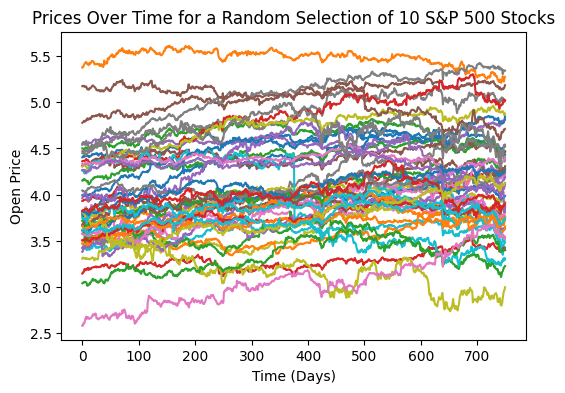

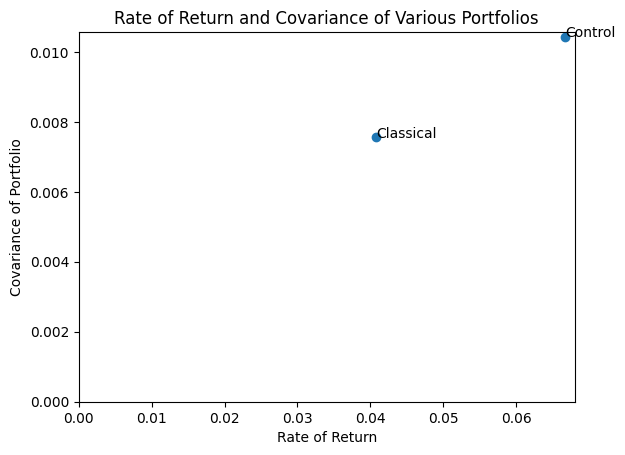

In [371]:
# Display example experiment results
# Using 50 stocks, training on the first 90 days of data
# Testing on subsequent 90 days of data
prices = get_stock_price(csv_path, 50)
results = run_experiment(prices, 0, 400, 400, 600)

print("\n")
print("Portfolio Weights:")
print(results['MVP Weights'])
print(results['Control Weights'])
print("\n")

print("Return Classical: ", results['MVP Return'])
print("Return Control: ", results['Control Return'])
print("\n")

print("Variance Classical: ", results['MVP Cov'])
print("Variance Control: ", results['Control Cov'])
print("\n")

print("Sharpe Ratio Classical: ", results['MVP Sharpe'])
print("Sharpe Ratio Control: ", results['Control Sharpe'])

np.log(prices.iloc[0:750]).plot(figsize=(6, 4), legend=False)
plt.xlabel("Time (Days)")
plt.ylabel("Open Price")
plt.title("Prices Over Time for a Random Selection of 10 S&P 500 Stocks")

x = [results['MVP Return'], results['Control Return']]
y = [results['MVP Cov'], results['Control Cov']]
labels = ["Classical", "Control"]
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.xlabel("Rate of Return")
plt.ylabel("Covariance of Portfolio")
plt.title("Rate of Return and Covariance of Various Portfolios")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    #ax.set_ylim(top=0.01)
    #ax.set_xlim(right=0.25)
plt.show()